In [75]:
# !pip install biosppy

In [73]:
from IPython.display import display
from IPython.core.display import HTML 



from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<center><b><font size="6">Detect Atrial fibrillation from EKG signals</font></b></center>

<br>
<img src="http://images.medicinenet.com//images/slideshow/atrial-fibrillation-s1-photo-of-atrial-fibrillation.jpg"></img>





### Problem ####
<p>
    <ul> 
        <li> AFib detection is not accurate </li>
        <li> Subtlelities in Afib causes signals to be detected as "normal"</li>
        
        <br/>
    </ul>
</p>

#### Status Quo
<ul>
    <li> AF is the most common sustained cardiac arrhythmia, occurring in 1-2% of the general population </li>
    <li> More than 12 million Europeans and North Americans are estimated to suffer from AF</li>
    <li> Prevalence will likely triple in the next 30-50 years </li>
</ul>

### Solution
   We will go through the following steps:
   - Read data
   - Feature Engineering (Accumulators, Broadcasters, ml/mllib APIs)
   - Data Visualizations (PixieDust, Seaborn)
   - Modeling (Spark ML)
   - Evaluation and prediction (Spark ML)
   - Deployment (Watson ML repository)

#### Machine Learning process ###

<center><img width="600px" height="600px" src="https://raw.githubusercontent.com/martinkearn/Content/master/Blogs/Images/MLProcess.PNG"></center>

### Architecture ###
<img src="https://raw.githubusercontent.com/joshishwetha/dsx-spark/master/arch.png" width="800px" height="500px"></img>


In [1]:
import scipy.io
import numpy as np
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from biosppy.signals import ecg

In [65]:
%matplotlib inline
plt.style.use('ggplot')

## 1. Read data
<img height="100px" width="100px" src="https://pbs.twimg.com/media/C5GJbFiVYAIl94t.png"></img>
<center>Data Connect </center>

<img height="100px" width="100px" src="https://mark.trademarkia.com/logo-images/bigsql/bigsql-85822451.jpg"></img>



<img height="100px" width="100px" src="https://media.licdn.com/mpr/mpr/AAEAAQAAAAAAAASuAAAAJDk3NGUwNWJkLWJkZGEtNGQzMy05OTJmLTIwZDc3OWU2MzZlYw.jpg"></img>


In [3]:
# The code was removed by DSX for sharing.

In [4]:
#get session cookie
headers = {'Content-Length': '32','Content-Type': 'application/x-www-form-urlencoded'}
params = {'username':serviceUsername, 'password':servicePassword}
url = serviceURL + '/_session'

resp_cookie = requests.post(url,headers=headers,data=params)

In [175]:
# %%time
# url = serviceURL+'/physionet/_all_docs?include_docs=True'
# docs = requests.get(url,cookies=resp_cookie.cookies)

In [174]:
# data_dump = docs.json()['rows']
# x = data_dump[0]['doc']
# x['label']

In [176]:
# %%time
# def convert_to_num(row):
#     vals = list(map(lambda x:float(x),row['data']))
#     return {'vals':vals, 'file':row['file'],'label':row['label']}

# dataset = list(map(lambda x:x['doc'],data_dump))
# dataset = list(map(lambda x:convert_to_num(x),dataset))

In [177]:
# %%time
# def normalize_vals(d):
#     vals_norm = list(map(lambda x:x/1000,d))
#     return vals_norm

# def process_signal(vals,sampling_rate):
#     out = ecg.ecg(signal=vals, sampling_rate=sampling_rate,show=False)
#     res = out.as_dict()
#     res['vals_norm'] = normalize_vals(vals)
#     return res

# res = list(map(lambda x:{'vals':x['vals'],
#                          'file':x['file'],
#                          'label':x['label'],
#                          'res':process_signal(x['vals'],300),
#                          },dataset))


In [78]:
res = list(filter(lambda x:x['label'] in ['A','N'],res))

In [79]:
pd.DataFrame(res[:10])

,file,label,res,vals
0,A08135,N,"{'ts': [0.0, 0.00333296296296, 0.0066659259259...","[260.0, 302.0, 352.0, 405.0, 444.0, 459.0, 463..."
1,A08150,N,"{'ts': [0.0, 0.00333300375717, 0.0066660075143...","[-481.0, -616.0, -778.0, -961.0, -1146.0, -131..."
2,A08186,N,"{'ts': [0.0, 0.00333296296296, 0.0066659259259...","[-75.0, -92.0, -107.0, -114.0, -118.0, -121.0,..."
3,A08189,N,"{'ts': [0.0, 0.00333296296296, 0.0066659259259...","[644.0, 762.0, 879.0, 993.0, 1091.0, 1145.0, 1..."
4,A08214,N,"{'ts': [0.0, 0.00333296296296, 0.0066659259259...","[119.0, 155.0, 209.0, 258.0, 308.0, 341.0, 371..."
5,A08277,N,"{'ts': [0.0, 0.00333296296296, 0.0066659259259...","[345.0, 417.0, 495.0, 579.0, 658.0, 705.0, 720..."
6,A08315,N,"{'ts': [0.0, 0.00333296296296, 0.0066659259259...","[-55.0, -62.0, -66.0, -70.0, -74.0, -78.0, -80..."
7,A08354,N,"{'ts': [0.0, 0.00333289206601, 0.0066657841320...","[4.0, 3.0, 2.0, 1.0, 1.0, 0.0, -1.0, -2.0, -3...."
8,A07732,A,"{'ts': [0.0, 0.00333296296296, 0.0066659259259...","[26.0, 32.0, 40.0, 50.0, 58.0, 62.0, 62.0, 61...."
9,A07791,N,"{'ts': [0.0, 0.00333296296296, 0.0066659259259...","[-515.0, -622.0, -736.0, -851.0, -946.0, -982...."


### Types of signals ###


In [80]:
conditions = list(map(lambda x:x['label'],res))
list(set(conditions))

['N', 'A']

### Alternatively, reading data with BigSQL 

    sampleDF = spark.read.format("jdbc")
      .option("url”,"jdbc:db2://yourHost.com:32051/BIGSQL")
      .option("dbtable",”yourSchema.t1")
      .option("user", "yourID").option("password", "yourPassword")
      .load() 


## 2.Feature Engineering 
- Convert raw EKG signals into R peak distributions (open source python package)


- Spark / Python 
- Spark MLlib/ Scikit learn

In [83]:
# conditions.index('N'), conditions.index('A')

## 3. Visualization 

<function matplotlib.pyplot.show>

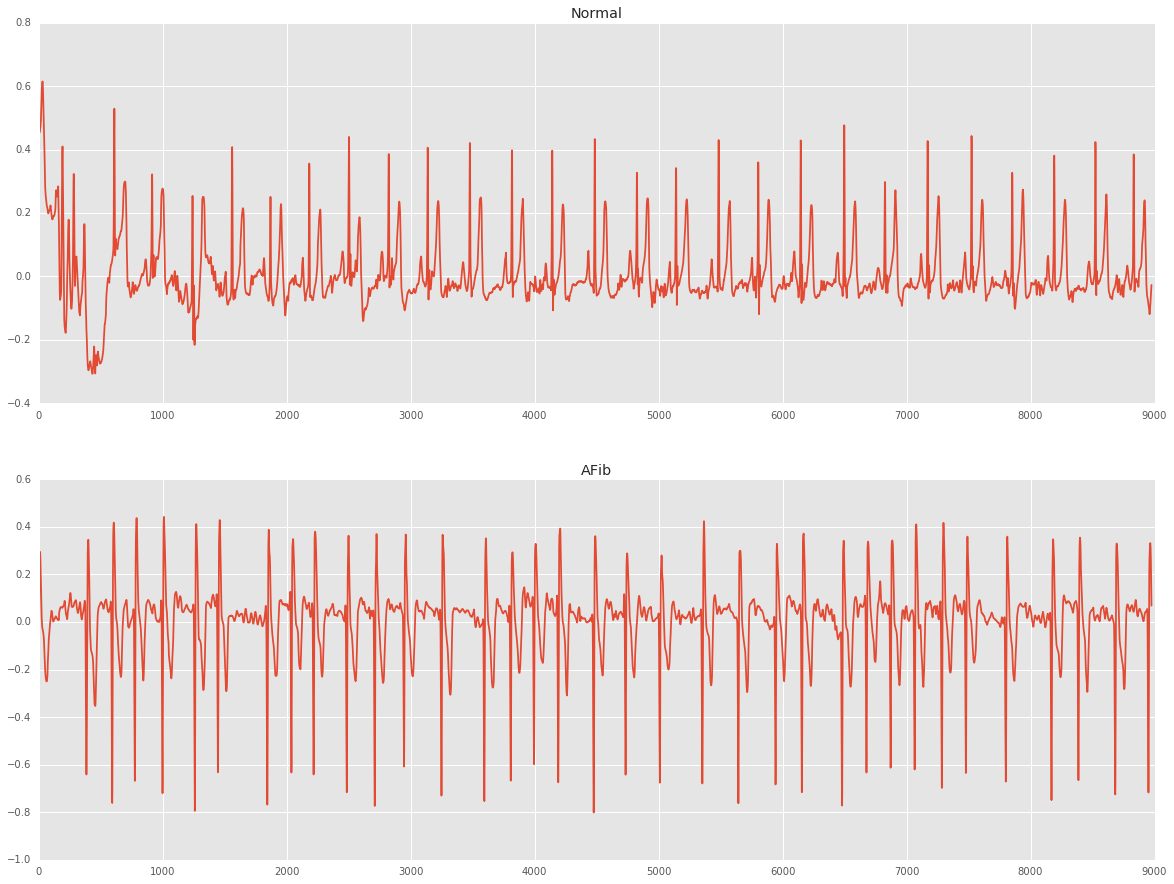

In [82]:
### plot data ###
%matplotlib inline
to_plot = [{'values':res[0],'label':'Normal'},
           {'values':res[8],'label':'AFib'}]
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(20,15))

for i,item in enumerate(to_plot):
    d, label = item['values'], item['label']
    y = list(d['res']['vals_norm'][24:])[:9000]
    x = list(range(len(y)))
    ax.flatten()[i].plot(x,y)
    ax.flatten()[i].set_title(label)
    
plt.show

## 4.Machine Learning 

### Vanilla statistics based

- summarize each signal by its mean r-peak and mean rr-interval 
- generate a distribution of each of the above datasets (so you get 2 dist overall)
- use the same function as above


### Spark Mllib
- Assemble a vector for each signal and label them
- feed into a multiclass classifier


### Deep learning
- generate images of each signal and feed into deep learning classifier

## Statistics approach

### 1) Collecting r-peak and rr_intervals distribution

In [93]:
%%time
import functools
def get_rpeak_vals(d):
    vals = list(map(lambda i:d['res']['vals_norm'][i],d['res']['rpeaks']))
    return np.mean(vals)

def get_rr_intervals(d):
    r_peaks_seconds = list(map(lambda x:x/300,d['res']['rpeaks']))
    rr_intervals = list(map(lambda x,y:y-x,r_peaks_seconds[:-1],r_peaks_seconds[1:]))
    return np.mean(rr_intervals)

r_peaks = list(map(lambda x:get_rpeak_vals(x),res))
rr_intervals = list(map(lambda x:get_rr_intervals(x),res))

CPU times: user 531 ms, sys: 56 ms, total: 587 ms
Wall time: 586 ms


In [94]:
### casting data into DFs for downstream analysis
r_peaks_df = pd.DataFrame(r_peaks,columns=['r_peak_mean'])
r_peaks_df = r_peaks_df.reset_index()

rr_intervals_df = pd.DataFrame(rr_intervals,columns=['rr_interval_mean'])
rr_intervals_df = rr_intervals_df.reset_index()

In [95]:
def get_moving_average(d,window_size):
    window = np.ones(window_size)/float(window_size)
    result = np.convolve(d,window,'same') # for same number of moving avg points
    return result


def get_anomalies(d,window_size,sigma=1):
    moving_avg = get_moving_average(d, window_size)
    residuals = np.subtract(d,moving_avg)
    
    #calc mean and std of residuals
    res_mean, res_std = np.mean(residuals),np.std(residuals)
    print ('Vanilla:',res_mean, res_std)
    
    #collect a list of points in the original signal more than 1 std away from residuals
    anomalies = [(i,point) for i,avg,point in zip(range(len(residuals)),moving_avg,d)
                           if point >(avg+(sigma*res_std)) or point <(avg-(sigma*res_std))]
    return {'vals':d,'anomalies':anomalies,'moving_avg':moving_avg}


def get_anomalies_rolling(d,window_size,sigma=1):
    moving_avg = get_moving_average(d, window_size)
    residuals = np.subtract(d,moving_avg)
    
    #calc mean and std of residuals (rolling vals using pandas)
    residuals_df = pd.DataFrame(residuals)
    res_mean, res_std = residuals_df.rolling(window_size).mean(),residuals_df.rolling(window_size).std()
    testing_std_as_df = pd.DataFrame(res_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    
    #collect a list of points in the original signal more than `sigma` std away from residuals
    anomalies = [(i,point) for i,avg,point,res_i in zip(range(len(residuals)),moving_avg,d,rolling_std)
                           if point >(avg+(sigma*res_i)) or point <(avg-(sigma*res_i))]
    
    return {'vals':d,'anomalies':anomalies,'moving_avg':moving_avg}

### 3) Test with a single signal and plot results

Vanilla: 0.00934523809524 0.0672618952802


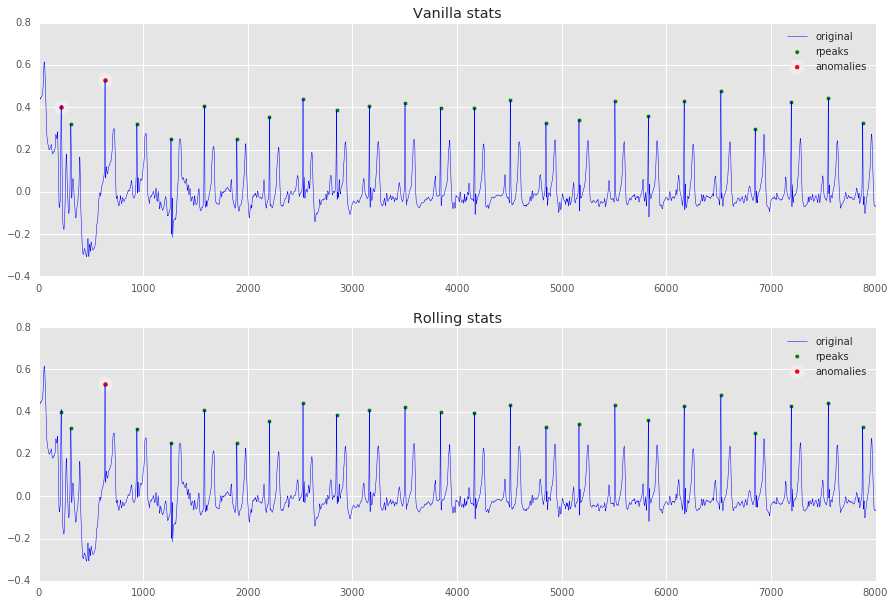

In [96]:
### prep data to be fed into anomaly detector ###
r_vals = [res[0]['res']['vals_norm'][i] for i in res[0]['res']['rpeaks'] ]
rpeaks = pd.DataFrame(list(zip(r_vals,res[0]['res']['rpeaks'])),columns=['point_vals','occ'])
d = r_vals

# get anomalies with vanilla mean and std
results = get_anomalies(d,3,2)
anomalies = pd.DataFrame(results['anomalies'],columns=['index','point_vals'])
ano = pd.merge(anomalies,rpeaks,on='point_vals',how='inner')

# get anomalies with rolling mean and std
results_rolling = get_anomalies_rolling(d,10,2)
anomalies_rolling = pd.DataFrame(results_rolling['anomalies'],columns=['index','point_vals'])
ano_rolling = pd.merge(anomalies_rolling,rpeaks,on='point_vals',how='inner')

## plot results
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.style.use('ggplot')
axes = ax.flatten()

axes[0].plot(list(range(len(res[0]['res']['vals_norm']))),list(res[0]['res']['vals_norm']),linewidth=0.5,c='blue',label='original')
axes[0].scatter(x=rpeaks['occ'],y=rpeaks['point_vals'],c='green',marker='o',label='rpeaks')
axes[0].scatter(x=ano['occ'],y=ano['point_vals'],c='red',marker='o',label='anomalies',linewidth=10)
axes[0].set_title('Vanilla stats')
axes[0].set_xlim([0,8000])
axes[0].legend()

axes[1].plot(list(range(len(res[0]['res']['vals_norm']))),list(res[0]['res']['vals_norm']),linewidth=0.5,c='blue',label='original')
axes[1].scatter(x=rpeaks['occ'],y=rpeaks['point_vals'],c='green',marker='o',label='rpeaks')
axes[1].scatter(x=ano_rolling['occ'],y=ano_rolling['point_vals'],c='red',marker='o',label='anomalies',linewidth=10)
axes[1].set_title('Rolling stats')
axes[1].set_xlim([0,8000])
axes[1].legend()

### 4) Feed distributions in to check anomalies

- Checking R-peak distribution

In [97]:
# get anomalies with vanilla mean and std
results = get_anomalies(r_peaks,3,3)
anomalies = pd.DataFrame(results['anomalies'],columns=['index','r_peak_mean'])

# get anomalies with rolling mean and std
results_rolling = get_anomalies_rolling(r_peaks,3,2)
anomalies_rolling = pd.DataFrame(results_rolling['anomalies'],columns=['index','r_peak_mean'])


Vanilla: 3.9562634642e-05 0.305253073127


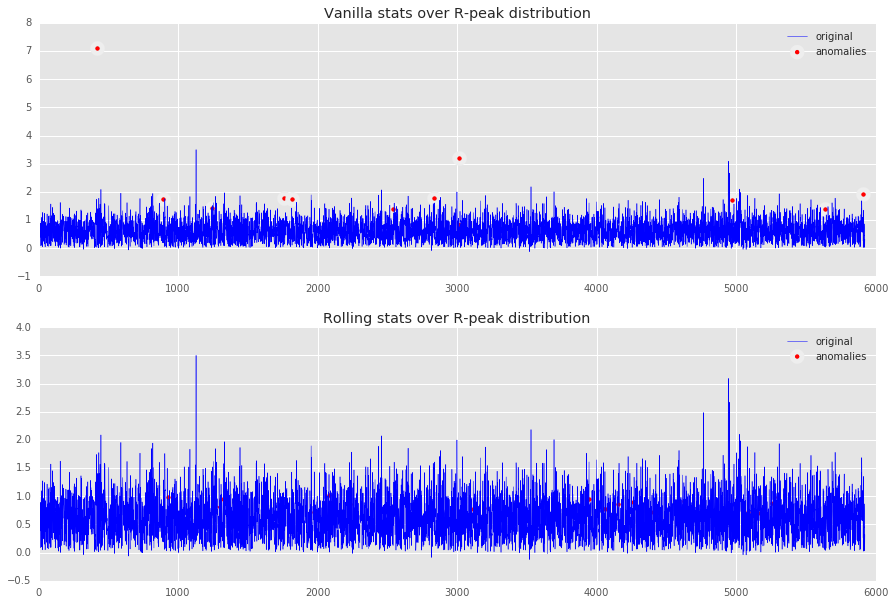

In [179]:
## plot results
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.style.use('ggplot')
axes = ax.flatten()

axes[0].plot(list(range(len(r_peaks))),list(r_peaks),linewidth=0.5,c='blue',label='original')
axes[0].scatter(x=list(anomalies['index']),y=list(anomalies['r_peak_mean']),c='red',marker='o',label='anomalies',linewidth=10)
axes[0].set_title('Vanilla stats over R-peak distribution')
axes[0].set_xlim([0,6000])
axes[0].legend()

axes[1].plot(list(range(len(r_peaks))),list(r_peaks),linewidth=0.5,c='blue',label='original')
axes[1].scatter(x=list(anomalies_rolling['index']),y=list(anomalies_rolling['r_peak_mean']),c='red',marker='o',label='anomalies',
                linewidth=10)
axes[1].set_title('Rolling stats over R-peak distribution')
axes[1].set_xlim([0,6000])
axes[1].legend()

In [99]:
#### Make labelled data easy to consume ####
ref_data = pd.DataFrame(list(map(lambda x:x['doc']['label'],data_dump)),columns=['label'])
ref_data = ref_data.reset_index()

# labels_count = ref_data.groupby('label').count()
# labels_count = labels_count.reset_index()
# labels_count

### Spark SQL
    query = """
    select label,
           count(1)
    from physionet
    group by label

    """
    spark.sql(query).toPandas()

In [108]:
df = spark.createDataFrame(ref_data)
df = df.filter(df.label.isin(['A','N']))
df.registerTempTable('physionet')

query = """
select label,
       count(1)
from physionet
group by label

"""
spark.sql(query).toPandas()

,label,count(1)
0,A,771
1,N,5153


In [111]:
ref_data = df.toPandas()

### Evaluate

In [112]:
classified_data = pd.merge(anomalies,ref_data,on='index')
classified_count = classified_data.groupby('label')['index'].count()
classified_count = classified_count.reset_index()
classified_count = pd.merge(classified_count,labels_count,on='label')
print ('Vanilla:\n',classified_count)

print ('\n')
classified_data = pd.merge(anomalies_rolling,ref_data,on='index')
classified_count = classified_data.groupby('label')['index'].count()
classified_count = classified_count.reset_index()
classified_count = pd.merge(classified_count,labels_count,on='label')
print ('Rolling:\n',classified_count)

Vanilla:
   label  index_x  index_y
0     A        2      771
1     N       19     5153


Rolling:
   label  index_x  index_y
0     A       11      771
1     N       73     5153


Vanilla: 0.000100604811949 0.143802148909


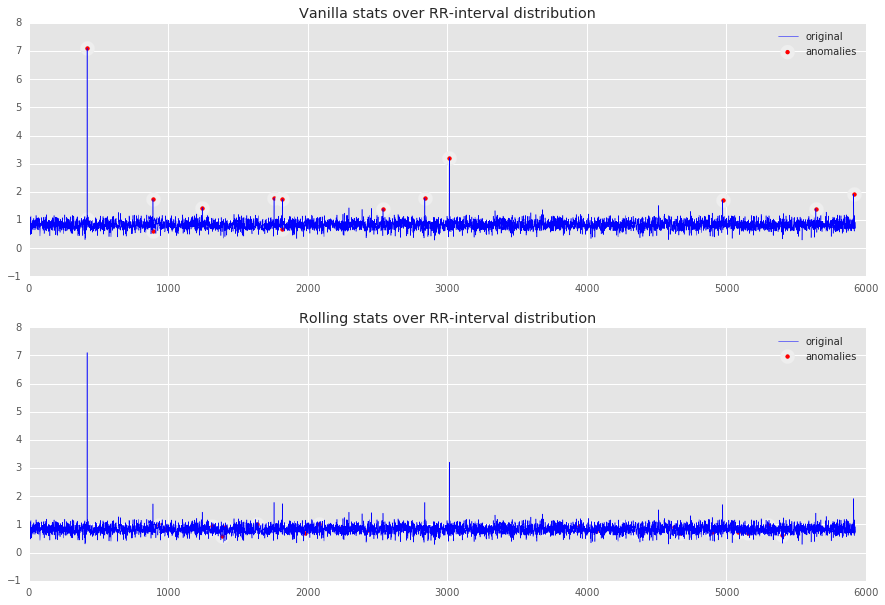

In [180]:
# get anomalies with vanilla mean and std
results = get_anomalies(rr_intervals,3,3)
anomalies = pd.DataFrame(results['anomalies'],columns=['index','r_peak_mean'])

# get anomalies with rolling mean and std
results_rolling = get_anomalies_rolling(rr_intervals,3,3)
anomalies_rolling = pd.DataFrame(results_rolling['anomalies'],columns=['index','r_peak_mean'])

## plot results
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.style.use('ggplot')
axes = ax.flatten()

axes[0].plot(list(range(len(rr_intervals))),list(rr_intervals),linewidth=0.5,c='blue',label='original')
axes[0].scatter(x=list(anomalies['index']),y=anomalies['r_peak_mean'],c='red',marker='o',label='anomalies',linewidth=10)
axes[0].set_title('Vanilla stats over RR-interval distribution')
axes[0].set_xlim([0,6000])
axes[0].legend()

axes[1].plot(list(range(len(rr_intervals))),list(rr_intervals),linewidth=0.5,c='blue',label='original')
axes[1].scatter(x=list(anomalies_rolling['index']),y=anomalies_rolling['r_peak_mean'],c='red',marker='o',label='anomalies',linewidth=10)
axes[1].set_title('Rolling stats over RR-interval distribution')
axes[1].set_xlim([0,6000])
axes[1].legend()

### Evaluate RR distribution

In [115]:
classified_data = pd.merge(anomalies,ref_data,on='index')
classified_count = classified_data.groupby('label')['index'].count()
classified_count = classified_count.reset_index()
classified_count = pd.merge(classified_count,labels_count,on='label')
print ('Vanilla:\n',classified_count)

print ('\n')
classified_data = pd.merge(anomalies_rolling,ref_data,on='index')
classified_count = classified_data.groupby('label')['index'].count()
classified_count = classified_count.reset_index()
classified_count = pd.merge(classified_count,labels_count,on='label')
print ('Rolling:\n',classified_count)

Vanilla:
   label  index_x  index_y
0     A        2      771
1     N        8     5153


Rolling:
   label  index_x  index_y
0     A        4      771
1     N       23     5153


## Use spark ML for multiclass classification
- Easy to use API
- Define stages to transform your dataset
- Select any estimator (model) for prediction 
- Each pipeline will model a single estimator onto your model


<center><img src="https://image.slidesharecdn.com/mlwithapachespark-2-160818115257/95/introduction-to-ml-with-apache-spark-mllib-47-638.jpg?cb=1490306278" width="500px" height="500px"></center>

In [116]:
#### Classification metrics ####
def calc_metrics(results,label_col,prediction_col):
    metrics = {}
    metrics['tp_0'] = results.filter((results[label_col]==0)&(results[prediction_col]==0)).count()
    metrics['fn_0'] = results.filter((results[label_col]==0)&(results[prediction_col]==1)).count()
    metrics['tn_0'] = results.filter((results[label_col]==1)&(results[prediction_col]==1)).count()
    metrics['fp_0'] = results.filter((results[label_col]==1)&(results[prediction_col]==0)).count()
    
    metrics['tp_1'] = results.filter((results[label_col]==1)&(results[prediction_col]==1)).count()
    metrics['fn_1'] = results.filter((results[label_col]==1)&(results[prediction_col]==0)).count()
    metrics['tn_1'] = results.filter((results[label_col]==0)&(results[prediction_col]==0)).count()
    metrics['fp_1'] = results.filter((results[label_col]==0)&(results[prediction_col]==1)).count()
    
    return metrics
        
### calc precision & recall ###
def precision_recall(results,label_col,prediction_col):
    items = calc_metrics(results,label_col,prediction_col)
    pre_0 = items['tp_0']/float((items['tp_0']+items['fp_0'])+1)
    pre_1 = items['tp_1']/float((items['tp_1']+items['fp_1'])+1)
    
    recall_0 = items['tp_0']/float((items['tp_0']+items['fn_0'])+1)
    recall_1 = items['tp_1']/float((items['tp_1']+items['fn_1'])+1)
    
    return {'pre_0':pre_0, 'recall_0':recall_0,'pre_1':pre_1,'recall_1':recall_1}

In [117]:
#### Classification metrics multi ####
def calc_metrics_multi(results,label_col,prediction_col):
    metrics = {}
    metrics['tp_0'] = results.filter((results[label_col]==0)&(results[prediction_col]==0)).count()
    metrics['fn_0'] = results.filter((results[label_col]==0)&(results[prediction_col]!=0)).count()
    metrics['tn_0'] = results.filter((results[label_col]!=0)&(results[prediction_col]!=0)).count()
    metrics['fp_0'] = results.filter((results[label_col]!=0)&(results[prediction_col]==0)).count()
    
    metrics['tp_1'] = results.filter((results[label_col]==1)&(results[prediction_col]==1)).count()
    metrics['fn_1'] = results.filter((results[label_col]==1)&(results[prediction_col]!=1)).count()
    metrics['tn_1'] = results.filter((results[label_col]!=1)&(results[prediction_col]!=1)).count()
    metrics['fp_1'] = results.filter((results[label_col]!=1)&(results[prediction_col]==1)).count()
    
    metrics['tp_2'] = results.filter((results[label_col]==2)&(results[prediction_col]==2)).count()
    metrics['fn_2'] = results.filter((results[label_col]==2)&(results[prediction_col]!=2)).count()
    metrics['tn_2'] = results.filter((results[label_col]!=2)&(results[prediction_col]!=2)).count()
    metrics['fp_2'] = results.filter((results[label_col]!=2)&(results[prediction_col]==2)).count()
    
    metrics['tp_3'] = results.filter((results[label_col]==3)&(results[prediction_col]==3)).count()
    metrics['fn_3'] = results.filter((results[label_col]==3)&(results[prediction_col]!=3)).count()
    metrics['tn_3'] = results.filter((results[label_col]!=3)&(results[prediction_col]!=3)).count()
    metrics['fp_3'] = results.filter((results[label_col]!=3)&(results[prediction_col]==3)).count()
    
    
    return metrics
        
### calc precision & recall ###
def precision_recall_multi(results,label_col,prediction_col):
    items = calc_metrics_multi(results,label_col,prediction_col)
    pre_0 = items['tp_0']/float((items['tp_0']+items['fp_0'])+1)
    pre_1 = items['tp_1']/float((items['tp_1']+items['fp_1'])+1)
    pre_2 = items['tp_2']/float((items['tp_2']+items['fp_2'])+1)
    pre_3 = items['tp_3']/float((items['tp_3']+items['fp_3'])+1)
    
    recall_0 = items['tp_0']/float((items['tp_0']+items['fn_0'])+1)
    recall_1 = items['tp_1']/float((items['tp_1']+items['fn_1'])+1)
    recall_2 = items['tp_2']/float((items['tp_2']+items['fn_2'])+1)
    recall_3 = items['tp_3']/float((items['tp_3']+items['fn_3'])+1)
    
    return {'pre_0':pre_0,'recall_0':recall_0,
            'pre_1':pre_1,'recall_1':recall_1,
            'pre_2':pre_2,'recall_2':recall_2,
            'pre_3':pre_3,'recall_3':recall_3}

In [118]:
### read and prep data ###
import pyspark.sql.functions as F 

def make_float(row):
    row = [float(x) for x in row]
    return row

#make dataframe
r_peak_data = list(map(lambda x,l:(x['res']['heart_rate'],len(x['res']['heart_rate']),l),res,ref_data['label']))
d = pd.DataFrame(r_peak_data,columns=['features','count','label'])
d = d[d['count']>0]
r_peak_records = d.to_records(index=False)

#value imputation for time series
rows = []
hr_len = 35
rows1 = list(filter(lambda x:len(x[0])>35,r_peak_data))
rows1 = list(map(lambda x:make_float(x[0][:35])+[x[1]]+[x[2]],rows1))
rows1 = list(map(lambda x:tuple(x),rows1))
    
columns = [str(i)+'_feature' for i in range(hr_len)]+['count','label']
df = spark.createDataFrame(rows1,schema=columns)

#define transformers
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

stringIndexer = StringIndexer(inputCol='label',outputCol='indexed')
encoder = OneHotEncoder(inputCol='indexed',outputCol='encoded')
assembler = VectorAssembler(inputCols=columns[:-2],outputCol='features')

#apply transformers to your data
indexed = stringIndexer.fit(df).transform(df)
assembled = assembler.transform(indexed)
dataset = assembled.select('features','label','count','indexed')
dataset_copy = dataset

In [120]:
###### PCA Visualize data ######
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import UserDefinedFunction
from pyspark.ml.feature import VectorAssembler 

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(dataset)

pca_result = model.transform(dataset)
result = pca_result.select("pcaFeatures")

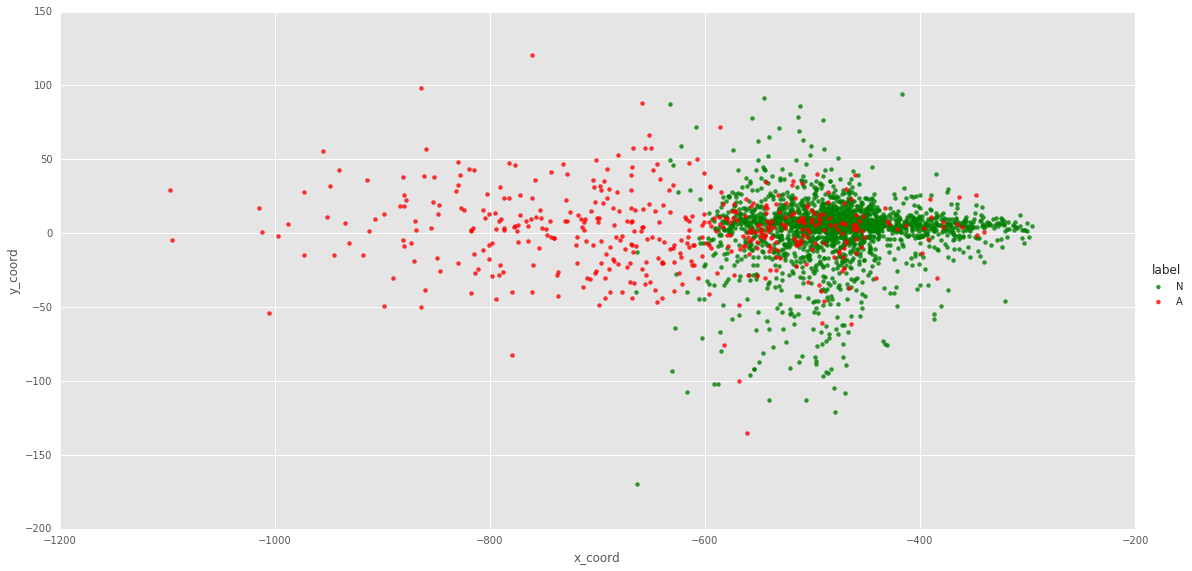

In [122]:
import regex
from pyspark.sql.types import StringType, FloatType
import seaborn as sns
from matplotlib import pyplot

def g(point,co_ord):
    if co_ord=='x':
        value = regex.split('\s+',point)[0][1:]
    else:
        value =  regex.split('\s+',point)[1][:-1]
    return value

get_x_coord = UserDefinedFunction(lambda point:g(point,'x'), StringType())
get_y_coord = UserDefinedFunction(lambda point:g(point,'y'), StringType())
convert_to_string = UserDefinedFunction(lambda point:str(point.toArray()),StringType())

pca_result = pca_result.withColumn('pcaFeatures_string',convert_to_string(pca_result['pcaFeatures']))
pca_result = pca_result.withColumn('x_coord',get_x_coord(pca_result['pcaFeatures_string']))\
                       .withColumn('y_coord',get_y_coord(pca_result['pcaFeatures_string']))
                      
pca_result = pca_result.withColumn('x_coord',pca_result.x_coord.cast(FloatType()))\
                       .withColumn('y_coord',pca_result.y_coord.cast(FloatType()))
    
viz_df = pca_result.select('x_coord','y_coord','label').toPandas()


a = sns.lmplot(x='x_coord',y='y_coord',hue='label',data=viz_df,
           fit_reg=False,palette={'A':'red','N':'green'},size=8,aspect=2)

### Evaluation

- Classification models work towards making a Yes/No decision
- Metrics to evaluate the model: Precision/Recall, AUC


<center><img width="500px" height="500px" src="http://opexanalytics.com/cnt/uploads/2016/01/Red-Fish-High-Recall.jpg"></center>

In [92]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# from pyspark.mllib.feature import Normalizer

# normalizer = Normalizer()
# features = dataset_copy.rdd.map(lambda x:x.features.toArray())
# labels = dataset_copy.rdd.map(lambda x:x.indexed)
# dataset_copy = labels.zip(normalizer.transform(features))
# dataset_copy = dataset_copy.toDF(schema=['label','features'])

In [173]:
# from pyspark.ml.linalg import DenseVector

# #split data into test and train
# dataset = dataset.filter(dataset.indexed.isin([0.0,2.0]))
# dataset = dataset.withColumn('indexed',F.when(dataset.indexed==2.0,1.0).otherwise(0.0))
# train_df, test_df = dataset.randomSplit([0.8,0.2])


### Decision Tree classifier

In [134]:
# define tree model and get predictions
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol='indexed',featuresCol='features',maxDepth=8)
dt_model = dt.fit(train_df)

predictions = dt_model.transform(test_df)
print ('Precision/Recall Tree classifier ')
precision_recall(predictions,'indexed','prediction')

Precision/Recall Tree classifier 


{'pre_0': 0.93026706231454,
 'pre_1': 0.7448979591836735,
 'recall_0': 0.9616564417177914,
 'recall_1': 0.6083333333333333}

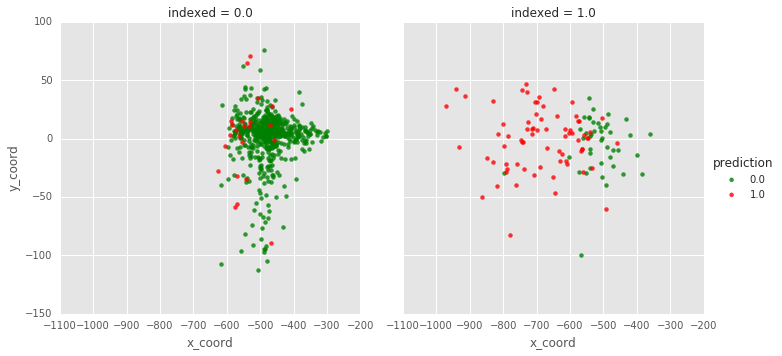

In [135]:
### Visualize the results of tree classifier ###
pca_subset = pca_result.select('features','x_coord','y_coord')
viz_df = pca_subset.join(predictions,on=['features']).select('x_coord','y_coord','prediction','indexed')
viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

a = sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='indexed',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green'},size=5,aspect=1)

### Logistic regression classifier

In [136]:
# define LR model and get predictions
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='indexed',featuresCol='features',regParam=0.5,maxIter=80)
lr_model = lr.fit(train_df)

predictions_lr = lr_model.transform(test_df)
print ('Precision/Recall LR classifier ')
precision_recall(predictions_lr,'indexed','prediction')

Precision/Recall LR classifier 


{'pre_0': 0.9004149377593361,
 'pre_1': 0.9795918367346939,
 'recall_0': 0.9984662576687117,
 'recall_1': 0.4}

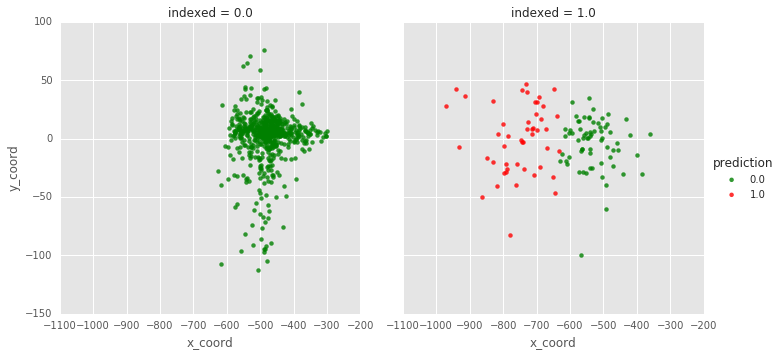

In [137]:
### Visualize the results of tree classifier ###
pca_subset = pca_result.select('features','x_coord','y_coord')
viz_df = pca_subset.join(predictions_lr,on=['features']).select('x_coord','y_coord','prediction','indexed')
viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

a = sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='indexed',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green',2:'yellow',3:'blue'},size=5,aspect=1)

### GBT

In [138]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Train a GBT model.
gbt = GBTClassifier(labelCol="indexed", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_df)
results_gbt = gbt_model.transform(test_df)
precision_recall(results_gbt,'indexed','prediction')

{'pre_0': 0.9352941176470588,
 'pre_1': 0.8260869565217391,
 'recall_0': 0.9754601226993865,
 'recall_1': 0.6333333333333333}

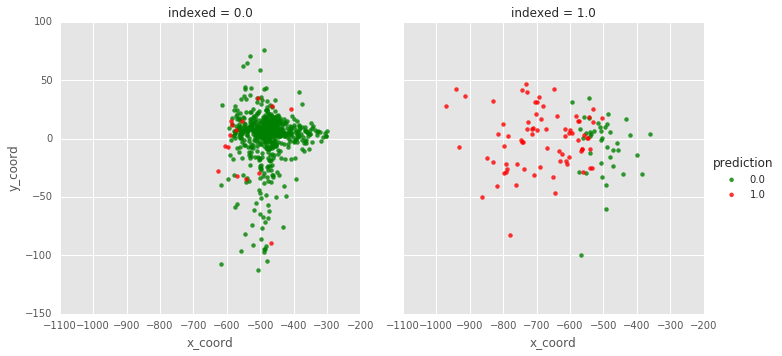

In [139]:
### Visualize the results of tree classifier ###
pca_subset = pca_result.select('features','x_coord','y_coord')
viz_df = pca_subset.join(results_gbt,on=['features']).select('x_coord','y_coord','prediction','indexed')
viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

a = sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='indexed',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green'},size=5,aspect=1)

In [171]:
# ### K-means clustering 
# from pyspark.ml.clustering import KMeans
# kmeans = KMeans(k=4,maxIter=10,seed=1,tol=0.001)
# model = kmeans.fit(dataset_copy.select('features'))

# # Evaluate clustering by computing Within Set Sum of Squared Errors.
# wssse = model.computeCost(dataset_copy)
# print("Within Set Sum of Squared Errors = " + str(wssse))

# # Shows the result.
# centers = model.clusterCenters()
# result = model.transform(dataset_copy)

# precision_recall(result,'indexed','prediction')

In [172]:
### One v/s all - Logistic regression ###
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# instantiate the base classifier.
lr = LogisticRegression(maxIter=50, tol=1E-6, fitIntercept=True,
                        featuresCol='features',labelCol='indexed')

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr, featuresCol='features',labelCol='indexed')

# split dataset and train the multiclass model.
train_df, test_df = dataset_copy.select(['features','indexed']).randomSplit([0.7,0.3])
ovrModel = ovr.fit(train_df)

# score the model on test data.
predictions = ovrModel.transform(test_df)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="f1",labelCol='indexed')

# compute the classification error on test data.
f1 = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - f1))


print ('Precision recall:\n',precision_recall_multi(predictions,'indexed','prediction'))

Test Error = 0.10304
Precision recall:
 {'recall_1': 0.5379310344827586, 'pre_0': 0.9095816464237517, 'recall_3': 0.0, 'recall_2': 0.0, 'recall_0': 0.9810771470160117, 'pre_2': 0.0, 'pre_1': 0.8571428571428571, 'pre_3': 0.0}


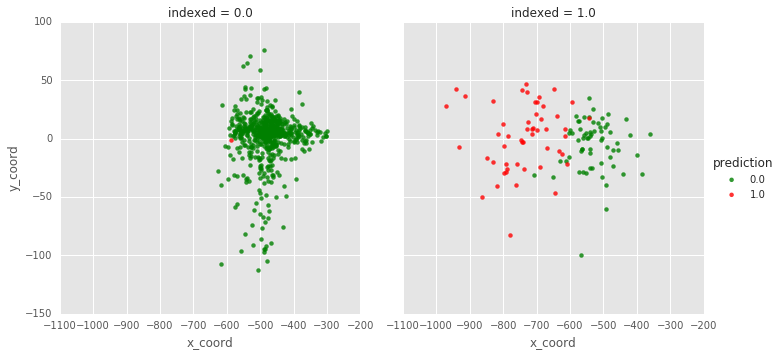

In [132]:
### Visualize the results of tree classifier ###
pca_subset = pca_result.select('features','x_coord','y_coord')
viz_df = pca_subset.join(predictions,on=['features']).select('x_coord','y_coord','prediction','indexed')
viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

a = sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='indexed',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green',2:'orange',3:'blue'},size=5,aspect=1)

## 5. Deploy 

- Deploy your model with a few lines of code
- Provides a link that can be embedded into applications (easy hand-off from data scientists to developers)

IBM WML Reference: http://watson-ml-api.mybluemix.net/#/Online32Scoring


In [163]:
# The code was removed by DSX for sharing.

In [166]:
### Required imports ###
import urllib3, requests, json

### Authenticate ML repo ###
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

ml_repository_client = MLRepositoryClient(service_path)
ml_repository_client.authorize(username, password)

### Save model ###
model_artifact_gbt = MLRepositoryArtifact(gbt_model, training_data=train_df, name="GBT Classifer")
saved_model = ml_repository_client.models.save(model_artifact_gbt)

### Get list of existing models, obtain scoring endpoint for the desired model ###

In [167]:
### get a list of existing deployments ###
url = service_path + "/v2/online/deployments"
header_online = {'Content-Type': 'application/json', 'Authorization': mltoken}

# get scoring endpoint for this model
resp = requests.get(url,headers=header_online)
scoring_href = resp.json()['resources'][0]['entity']['scoringHref']

In [168]:
### example of getting prediction with online scoring ####
test_row = test.take(5)[3]
test_features = [test_row[col] for col in test.columns if col not in ['label']]

# get prediction from online scoring endpoint (scoring_href from above)
payload_scoring = {"record":test_features}
response_scoring = requests.put(scoring_href, json=payload_scoring, headers=header_online)

#### prediction_endpoint = "https://ibm-watson-ml.mybluemix.net/32768/v2/scoring/1751"

## Iterate 

### 1. Deep Learning ###

<img src="http://www.kdnuggets.com/wp-content/uploads/neural-networks-layers.jpg"></src>

### Import Keras

In [141]:
from __future__ import print_function
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
from keras import regularizers

Using TensorFlow backend.


In [142]:
label_transformer = OneHotEncoder(inputCol='indexed',outputCol='label_index',dropLast=False)
train_df = label_transformer.transform(train_df)
test_df = label_transformer.transform(test_df)

In [143]:
X_train = list(map(lambda x:x.features.toArray(),train_df.select('features').collect()))
X_test= list(map(lambda x:x.features.toArray(),test_df.select('features').collect()))

Y_train = list(map(lambda x:x.label_index.toArray(),train_df.select('label_index').collect()))
Y_test = list(map(lambda x:x.label_index.toArray(),test_df.select('label_index').collect()))

In [169]:
X_train = np.matrix(X_train)
Y_train = np.matrix(Y_train)

print ("Train shapes")
Y_train.shape, X_train.shape

Train shapes


((1868, 2), (1868, 35))

In [170]:
X_test = np.matrix(X_test)
Y_test = np.matrix(Y_test)

print ("Test shapes")
X_test.shape, Y_test.shape

Test shapes


((770, 35), (770, 2))

#### Build network

In [145]:
np.random.seed(1671) # for reproducibility

# network and training
NB_EPOCH = 200
BATCH_SIZE = 128 #number of input instances trained before the network readjusts its weights
VERBOSE = 1
NB_CLASSES = 2 # number of output classes
INPUT_LENGTH = 35

#optimizer (choose between SGC(), RMSprop(), Adam())
OPTIMIZER = Adam() # SGD optimizer, explained later in this chapter
N_HIDDEN = 64
VALIDATION_SPLIT=0.2 # how much TRAIN is reserved for VALIDATION

#dropout(regularization)
DROPOUT = 0.3

In [146]:
model = Sequential()

#input 
model.add(Dense(NB_CLASSES, input_shape=(INPUT_LENGTH,)))
model.add(Activation('softmax'))
#hidden layer 1
model.add(Dense(100))
model.add(Activation('softmax'))
#hidden layer 2
model.add(Dense(150))
model.add(Activation('softmax'))
#dropout layer (regularization)
model.add(Dropout(DROPOUT))
#hidden layer 3
model.add(Dense(100))
model.add(Activation('relu'))
# output layer
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 2)             72          dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 2)             0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 100)           300         activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 100)           0           dense_2[0][0]                    
___________________________________________________________________________________________

In [147]:
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['precision','recall'])

In [148]:
history = model.fit(X_train, Y_train,
    batch_size=BATCH_SIZE, nb_epoch=200,
    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 1494 samples, validate on 374 samples
Epoch 1/200
1494/1494 [==============================] - 0s - loss: 0.6615 - precision: 0.7651 - recall: 0.7651 - val_loss: 0.6263 - val_precision: 0.8021 - val_recall: 0.8021
Epoch 2/200
1494/1494 [==============================] - 0s - loss: 0.5943 - precision: 0.8106 - recall: 0.8106 - val_loss: 0.5627 - val_precision: 0.8021 - val_recall: 0.8021
Epoch 3/200
1494/1494 [==============================] - 0s - loss: 0.5346 - precision: 0.8106 - recall: 0.8106 - val_loss: 0.5184 - val_precision: 0.8021 - val_recall: 0.8021
Epoch 4/200
1494/1494 [==============================] - 0s - loss: 0.5001 - precision: 0.8106 - recall: 0.8106 - val_loss: 0.4996 - val_precision: 0.8021 - val_recall: 0.8021
Epoch 5/200
1494/1494 [==============================] - 0s - loss: 0.4868 - precision: 0.8106 - recall: 0.8106 - val_loss: 0.4976 - val_precision: 0.8021 - val_recall: 0.8021
Epoch 6/200
1494/1494 [==============================] - 0s - loss: 0.484

In [161]:
score = model.evaluate(X_test, Y_test)
print ("\n")
print ("Loss:",score[0])
print ("Precision:",score[1])
print ("Recall:",score[2])

770/770 [==============================] - 0s     


Loss: 0.434353736894
Precision: 0.845454545455
Recall: 0.845454545455


#### One v/s All Approaches
- Bring in Additional data 

### Streaming data sources

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# instantiate the base classifier.
dt = DecisionTreeClassifier(labelCol='indexed',featuresCol='features',maxDepth=20,impurity='entropy')
# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=dt, featuresCol='features',labelCol='indexed')

# split dataset and train the multiclass model.
train_df, test_df = dataset_copy.select(['features','indexed']).randomSplit([0.7,0.3])
ovrModel = ovr.fit(train_df)

# score the model on test data.
predictions = ovrModel.transform(test_df)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="f1",labelCol='indexed')

# compute the classification error on test data.
f1 = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - f1))


print ('Precision recall:\n',precision_recall_multi(predictions,'indexed','prediction'))